<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.983 · Aprenentage per reforç</p>
<p style="margin: 0; text-align:right;">2024-1 · Màster universitari en Ciència de dades (<i>Data science</i>)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudis d'Informàtica, Multimèdia i Telecomunicació</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>

<div class="alert alert-block alert-info">
    <strong>Nombre y apellidos:</strong> Indicar aquí el nombre y apellidos
</div>

# PAC 1 - Solucions tabulars

En aquesta pràctica implementarem els diferents mètodes d'aprenentatge per reforç estudiats als Blocs I i II del curs. En concret, ens centrarem en la definició d'un entorn i implementarem els diferents mètodes per buscar una solució òptima del problema.

**<u>Important</u>: El lliurament s'ha de fer en format notebook i en format html on es vegi el codi, els resultats i comentaris de cada exercici. És a dir, s'han de lliurar dos fitxers: un amb extensió .ipynb i un altre .html. Per exportar el notebook a html pot fer-se des del menú File $\to$ Download as $\to$ HTML. A més s'han de lliurar els 2 arxius que es modificaran dins de la carpeta <code>\gym_gridworlds</code>, els arxius <code>gridworld.py</code> i <code>\_\_init\_\_.py</code>.**


## 1. L'entorn __Gym-Gridworlds__ (1 punt)

L'entorn __Gym-Gridworlds__ és un entorn de tercers que es troba referenciat a la web de Gymnasium, concretament a l'apartat 'ENVIRONMENTS/External Environments'.

L'entorn consisteix en un agent que es mou en una quadrícula de dimensions configurables. La classe per defecte `Gridworld` implementa una tasca "anar a l'objectiu" on l'agent té cinc accions (esquerra, dreta, amunt, avall, romandre al lloc) i una funció de transició predeterminada (seleccionar l'acció "romandre al lloc" als estats objectiu acaba l'episodi).

El codi i la documentació es troba a https://github.com/sparisi/gym_gridworlds

Es recomana llegir atentament la pàgina per familiaritzar-se amb l'entorn.

**<u>Nota</u>: L'entorn utilitzat té un mode de renderitzat <code>render\_mode = "human"</code> que permet observar la quadrícula i el moviment de l'agent en una pantalla adicional utiltzant el paquet <code>pygame</code> de python. Aquest mode de renderitzat només funciona en local. Per a poder executar el codi sense problemes es proporciona un arxiu <code>environment.yml</code> perquè pugueu crear un entorn virtual amb els paquets necessaris.**

Començarem carregant un dels múltiples entorns pre-dissenyats i veurem les seves principals característiques, executant un episodi de prova.

### 1.1. Càrrega de dades (0.5 punts)

El següent codi carrega els paquets necessaris per a l'exemple.

Comencem instal·lant Gymnasium (això només s'ha de fer una vegada si no ho teniu instal·lat ja).

In [1]:
!pip install gymnasium==1.0.0

In [2]:
import gymnasium as gym
print("La versió de Gymnasium utilitzada en aquesta PAC s la 1.0.0, comprova-ho a continuació")
print("Gymnasium Version:", gym.__version__) # 0.28.1

La versió de Gymnasium utilitzada en aquesta PAC s la 1.0.0, comprova-ho a continuació
Gymnasium Version: 1.0.0


A continuació clonem el repositori de l'entorn (això només s'ha de fer una vegada).

In [ ]:
!git clone https://github.com/sparisi/gym_gridworlds.git

Entrem dins del directori `gym_gridworlds` i l'instal·lem en mode editable (això només s'ha de fer una vegada).

In [ ]:
!cd gym_gridworlds
!pip install -e .

Importem els paquets necessaris per la resta de la PAC

In [3]:
import numpy as np
from matplotlib import pyplot as plt
from collections import defaultdict
import sys
import time
import gym_gridworlds

Creem l'entorn mitjançant la instanciació d'un objecte de classe `Gridworld` (en executar la instrucció `env = gym.make("Gym-Gridworlds/Full-4x5-v0", render_mode="human")`) i imprimim per pantalla el tipus de l'espai d'accions i de l'espai d'observacions.

In [4]:
env = gym.make("Gym-Gridworlds/Full-4x5-v0", render_mode="human")
env.reset()
env.render()
print("Action space is {} ".format(env.action_space))
print("Observation space is {} ".format(env.observation_space))

Action space is Discrete(5) 
Observation space is Discrete(20) 


L'entorn generat té el següent aspecte (comprovar-ho a la finestra emergent de <code>pygame</code> que es genera a l'executar <code>env.render()</code>):
<br><br>
<img src="images/Gym-Gridworld_4x5.png" alt="Mi imagen" style="display: block; margin-left: auto; margin-right: auto;">

En aquest entorn podem veure una sèrie de caselles i figures que es descriuen a continuació:

<ul>
  <li>Les caselles negres són buides.</li>
  <li>Les caselles negres amb fletxes grises són caselles on l'agent només es pot moure en una direcció (les altres accions fallaran).</li>
  <li>Les caselles vermelles donen recompenses negatives (com més brillants, més negatives).</li>
  <li>Les caselles verdes donen recompenses positives (com més brillants, més altes).</li>
  <li>Les caselles grogues són arenes movedisses, on totes les accions fallaran amb un 90% de probabilitat.</li>
  <li>L'agent és el cercle blau.</li>
</ul>

A més, hi ha altres tipus de caselles:

<ul>
  <li>Les caselles blanques són pous (caminar-hi comporta una gran recompensa negativa i l'episodi acaba).</li>
  <li>Les caselles porpres són parets (l'agent no hi pot passar).</li>
  <li>Una fletxa taronja indica l'última acció de l'agent.</li>
  <li>Un punt taronja indica que l'agent no va intentar moure's amb la seva última acció.</li>
</ul>



<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Exercici 1.1</strong> (0.5 pts)

Analitzar la [documentació](https://github.com/sparisi/gym_gridworlds) i el codi de l'entorn que es troba a <code>\gym_gridworlds\gridworld.py</code> per respondre a les següents preguntes:
<ul>    
    <li>Descriure l'espai d'accions de l'entorn: quantes accions hi ha? a què correspòn cadascuna d'elles?</li>
    <li>Quina és la casella inicial? Es pot canviar?</li>
</ul></div>

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentaris:</strong>
<br>
<ul>
    <li>Hi ha 5 accions diferents.</li>
    <ul>
        <li>0: "Move Left"</li>
        <li>1: "Move Down"</li>
        <li>2: "Move Right"</li>
        <li>3: "Move Up"</li>
        <li>4: "Stay"</li>
    </ul>
<li>En quant a la casella inicial:</li>
    <ul>
        <li>Per defecte es troba a dalt a l'esquerra.</li>
        <li>Es pot canviar fent una sub-classe de la classe <code>Gridworld</code> i re-escribint el mètode <code>_reset()</code></li>
    </ul>
</ul>
</div>

### 1.2. Execució d'un episodi (0.5 punts)

A continuació, realitzarem l'execució d'un episodi de l'entorn *Gym-Gridworlds/Full-4x5-v0* utilitzant un agent que selecciona les accions de forma aleatòria.
  

In [5]:
# Inicialitzem l'entorn
obs, info = env.reset()
t, total_reward, terminated, truncated = 0, 0, False, False

print("Obs inicial: {} ".format(obs))

switch_action = {
        0: "Left",
        1: "Down",
        2: "Right",
        3: "Up",
        4: "Stay",
    }
done = False
while not done:

    # Triar una acció aleatòria (aquesta és la implementació de l'agent)
    action = env.action_space.sample()

    # Executar l'acció i esperar la resposta de l'entorn
    new_obs, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    # Imprimir time-step
    print("Step {}. Action: {} -> Obs: {} and reward: {}. Terminated {}. Truncated {}.".format(t+1, switch_action[action], new_obs, reward, terminated, truncated))

    # Actualitzar variables
    obs = new_obs
    total_reward += reward
    t += 1
    time.sleep(0.5) #S'afegeix per alentir el renderitzat i poder apreciar els moviments de l'agent

print("Episode finished after {} timesteps and reward was {} ".format(t, total_reward))

Obs inicial: 0 
Step 1. Action: Stay -> Obs: 0 and reward: 0.0. Terminated False. Truncated False.
Step 2. Action: Stay -> Obs: 0 and reward: 0.0. Terminated False. Truncated False.
Step 3. Action: Left -> Obs: 0 and reward: 0.0. Terminated False. Truncated False.
Step 4. Action: Stay -> Obs: 0 and reward: 0.0. Terminated False. Truncated False.
Step 5. Action: Down -> Obs: 5 and reward: 0.0. Terminated False. Truncated False.
Step 6. Action: Left -> Obs: 5 and reward: 0.0. Terminated False. Truncated False.
Step 7. Action: Stay -> Obs: 5 and reward: 0.0. Terminated False. Truncated False.
Step 8. Action: Down -> Obs: 10 and reward: 0.0. Terminated False. Truncated False.
Step 9. Action: Right -> Obs: 11 and reward: 0.0. Terminated False. Truncated False.
Step 10. Action: Up -> Obs: 6 and reward: 0.0. Terminated False. Truncated False.
Step 11. Action: Left -> Obs: 5 and reward: 0.0. Terminated False. Truncated False.
Step 12. Action: Right -> Obs: 6 and reward: 0.0. Terminated False. 

Es recomana analitzar el codi anterior, executar-lo vàries vegades i observar el renderitzat en la finestra emergent externa abans de contestar el següent exercici.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Exercici 1.2</strong> (0.5 pts)

Una vegada executat l'episodi, i en base a l'anàlisi de la documentació i del codi de l'entorn, respondre a les següents preguntes:
<ul>
    <li>Descriure l'espai d'estats: en què consisteixen els estats? com es codifiquen per defecte?</li>
    <li>Descriure el senyal de recompensa: quins valors pot prendre? en quines situacions es rep cada valor?</li>
    <li>Quan finalitza un episodi?</li>
</ul></div>

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentaris:</strong>
<br>
<ul>
    <li>L'espai d'estats consisteix en un conjunt de números enters que identifiquen cada casella:</li>
    <ul>
        <li>El seu rang és [0,nombre de caselles-1]</li>
        <li>La numeració comença amb 0 a la casella de dalt a l'esquerra i es va propagant d'esquerra a dreta i de dalt a baix.</li>
    </ul>
    <li>El senyal de recompensa és una variable real que pot prendre els següents valors en funció dels estats i les accions seleccionades:</li>
    <ul>
        <li>Seleccionar l'acció <code>STAY</code> a la casella objectiu (color verd brillant): +1</li>
        <li>Seleccionar l'acció <code>STAY</code> a la casella objectiu de distracció (color verd fosc): +0.1</li>
        <li>Qualsevol acció en caselles de penalització (vermell brillant): -10</li>
        <li>Qualsevol acció en caselles de penalització petita (vermell fosc, granat): -0.1</li>
        <li>Caminar sobre una casella de pou (blanx): -100</li>
        <li>Altrament: 0</li>
    </ul>
    <li>De manera predeterminada, un episodi finalitza si passa alguna de les situacions següents:</li>
    <ul>
        <li>S'obté una recompensa positiva (terminació).</li>
        <li>Caminar sobre una casella de pou (terminació).</li>
        <li>La longitud de l'episodi arriba a <code>max_episode_steps</code> (truncament).</li>
    </ul>
</ul>
</div>

Tanquem l'entorn perquè als següents apartats en crearem un de nou

In [6]:
env.close()

## 2. Creació d'un entorn propi (1,5 punts)

L'entorn *Gym-Gridworld* té diversos arguments que poden ser modificats:

* La dimensió de la quadrícula.
* El tipus de cada casella.
* La posició de les caselles de sortida i d'arribada.
* ...

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Exercici 2.1</strong> (0,75 punts)

Crear un entorn nou com el que es descriu a continuació:

<ul>
  <li>Graella 4x4</li>
  <li>Les 4 caselles centrals son de tipus paret (color porpra).</li>
  <li>Casella d'inici a dalt a l'esquerra (posició per defecte).</li>
  <li>Casella final (color verd brillant) a baix a la dreta.</li>
  <li>La casella de la dreta del tot de la primera fila que sigui amb penalització gran (color vermell brillant).</li>
  <li>La resta de caselles, en comptes de ser normals (color negre) posar-les amb una petita penalització (color vermell fosc).</li>
</ul>

Per a realitzar l'entorn:
<ul>
  <li>Heu d'afegir la graella al diccionari <code>GRIDS</code> de l'arxiu <code>\gym_gridworlds\gridworld.py</code> (utilitzeu com a clau de l'entrada al diccionari <code>"4X4_Ex2"</code>.)</li>
  <li>Heu de registrar l'entorn a l'arxiu <code>\gym_gridworlds\__init__.py</code> amb les següents dades:</li>
      <ul>
          <li><code>id="Gym-Gridworlds/Ex2-4x4-v0"</code></li>
          <li><code>entry_point="gym_gridworlds.gridworld:Gridworld"</code></li>
          <li><code>max_episode_steps=100</code></li>
          <li><code>kwargs={"grid": "4X4_Ex2",}</code></li>
       </ul>
</ul>
</div>

Una vegada afegit i registrat el nou entorn re-inicieu el kernel del Notebook per a que es pugui carregar i executar.

Si tot ha anat bé, després d'executar el següent codi, hauríeu d'obtenir un entorn amb el següent aspecte:
<br><br>
<img src="images/Gym-Gridworld_Ex2_4x4.png" alt="Mi imagen" style="display: block; margin-left: auto; margin-right: auto;">



In [7]:
import gym_gridworlds
env = gym.make("Gym-Gridworlds/Ex2-4x4-v0", render_mode="human")
env.reset()
env.render()
print("Action space is {} ".format(env.action_space))
print("Observation space is {} ".format(env.observation_space))

Action space is Discrete(5) 
Observation space is Discrete(16) 


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Exercici 2.2</strong> (0,25 punts)

A continuació, implementar un agent que dugui a terme una política aleatòria. Comprovar que les caselles visitades i les recompenses rebudes es corresponen amb les accions i l'entorn programat.

Mostrar la trajectòria seguida per l'agent. No cal graficar-la , tan sols mostrar les accions i les caselles visitades en ordre i les recompenses rebudes.

Mostrar també el nombre de *steps* i la recompensa total acumulada.
</div>

In [8]:
# Inicialitzem l'entorn
obs, info = env.reset()
t, total_reward, terminated, truncated = 0, 0, False, False

print("Obs inicial: {} ".format(obs))

switch_action = {
        0: "Left",
        1: "Down",
        2: "Right",
        3: "Up",
        4: "Stay",
    }

Obs inicial: 0 


In [9]:
######################## SOLUCIÓ ###########################

done = False
while not done:

    # Triar una acció aleatòria (aquesta és la implementació de l'agent)
    action = env.action_space.sample()

    # Executar l'acció i esperar la resposta de l'entorn
    new_obs, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    # Imprimir time-step
    print("Step {}. Action: {} -> Obs: {} and reward: {}. Terminated {}. Truncated {}.".format(t+1, switch_action[action], new_obs, reward, terminated, truncated))

    # Actualitzar variables
    obs = new_obs
    total_reward += reward
    t += 1
    time.sleep(0.5)

print("Episode finished after {} timesteps and total reward was {} ".format(t, total_reward))


Step 1. Action: Stay -> Obs: 0 and reward: -0.1. Terminated False. Truncated False.
Step 2. Action: Left -> Obs: 0 and reward: -0.1. Terminated False. Truncated False.
Step 3. Action: Up -> Obs: 0 and reward: -0.1. Terminated False. Truncated False.
Step 4. Action: Down -> Obs: 4 and reward: -0.1. Terminated False. Truncated False.
Step 5. Action: Stay -> Obs: 4 and reward: -0.1. Terminated False. Truncated False.
Step 6. Action: Left -> Obs: 4 and reward: -0.1. Terminated False. Truncated False.
Step 7. Action: Stay -> Obs: 4 and reward: -0.1. Terminated False. Truncated False.
Step 8. Action: Stay -> Obs: 4 and reward: -0.1. Terminated False. Truncated False.
Step 9. Action: Left -> Obs: 4 and reward: -0.1. Terminated False. Truncated False.
Step 10. Action: Stay -> Obs: 4 and reward: -0.1. Terminated False. Truncated False.
Step 11. Action: Left -> Obs: 4 and reward: -0.1. Terminated False. Truncated False.
Step 12. Action: Left -> Obs: 4 and reward: -0.1. Terminated False. Truncate

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Pregunta</strong>
Quin pot ser l'ojectiu d'utilitzar caselles de collor vermell fosc (amb una petita penalització) en comptes de caselles negres (sense penalització) en l'entrenament dels agents?
</div>

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentaris:</strong>
<br><br>
Això es fa per a condicionar a l'agent a que intenti trobar el camí més ràpid cap a l'objectiu.
</div>


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Exercici 2.3</strong> (0,5 punts)

A continuació, implementar un agent que dugui a terme la política òptima determinista, és a dir, que partint de la casella inicial [0,0] arribi a la casella final (de color verd brillant) amb la màxima recompensa acumulada. Quin és el valor del nombre de passos mínims? Quin és el retorn obtingut?

Mostra la trajectòria seguida per l'agent i el retorn obtingut. No cal graficar-la, tan sols mostrar les accions i les caselles visitades en ordre i el retorn (recompensa total acumulada).

Comenta els resultats.

</div>

In [10]:
# Inicialitzem l'entorn
obs, info = env.reset()
t, total_reward, terminated, truncated = 0, 0, False, False

print("Obs inicial: {} ".format(obs))

switch_action = {
        0: "Left",
        1: "Down",
        2: "Right",
        3: "Up",
        4: "Stay",
    }

Obs inicial: 0 


In [11]:
######################## SOLUCIÓ ###########################

# Definim una llista amb la política òptima
optimal_policy = [1, 1, 1, 2, 2, 2, 4]

# Li donem la volta a la llista per treure'ls d'un en un en l'ordre correcte

optimal_policy.reverse()

done = False
while not done:

    # Extreure una acció de la llista d'accions òptimes
    action = optimal_policy.pop()

    new_obs, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    # Imprimir time-step
    print("Step {}. Action: {} -> Obs: {} and reward: {}. Terminated {}. Truncated {}.".format(t+1, switch_action[action], new_obs, reward, terminated, truncated))


    # Actualitzar variables
    obs = new_obs
    total_reward += reward
    t += 1

print("Episode finished after {} timesteps and total reward was {} ".format(t, total_reward))
env.close()




Step 1. Action: Down -> Obs: 4 and reward: -0.1. Terminated False. Truncated False.
Step 2. Action: Down -> Obs: 8 and reward: -0.1. Terminated False. Truncated False.
Step 3. Action: Down -> Obs: 12 and reward: -0.1. Terminated False. Truncated False.
Step 4. Action: Right -> Obs: 13 and reward: -0.1. Terminated False. Truncated False.
Step 5. Action: Right -> Obs: 14 and reward: -0.1. Terminated False. Truncated False.
Step 6. Action: Right -> Obs: 15 and reward: -0.1. Terminated False. Truncated False.
Step 7. Action: Stay -> Obs: 15 and reward: 1.0. Terminated True. Truncated False.
Episode finished after 7 timesteps and total reward was 0.4 


<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentaris:</strong>
<br><br>
La política òptima és aquella que provoca que l'agent arribi a la casella final (de color verd brillant) evitant la casella de màxima penalització (de color vermell brillant).

S'aconsegueix en 7 passes i el retorn és de 0.4.

</div>


## 3. Mètodes de Montecarlo (2 punts)

L'objectiu d'aquest apartat és realitzar una estimació de la política òptima mitjançant els mètodes de Montecarlo. En concret estudiarem l'algoritme *On-policy first-visit MC control* (per a polítiques $\epsilon$-soft).

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Exercici 3.1</strong> (1 punt)

Implementar l'Algorisme 3 explicat en el mòdul "Mètodes de Montecarlo": *On-policy first-visit MC control (per a polítiques $\epsilon$-soft)* utilitzant els següents paràmetres:
    
<ul>
  <li>Nombre d'episodis = 50.000</li>
  <li>Epsilon inicial = 0,5</li>
  <li>Factor de decaïment d'epsilon (*epsilon decay*) = 0,999</li>
  <li>Mínim valor d'epsilon (*epsilon_min*) = 0,05</li>
  <li>Actualitzar epsilon segons:  $$\textrm{max}(\epsilon · \epsilon_{\textrm{decay}}, \epsilon_{\textrm{min}})$$</li>
  <li>Factor de descompte = 1</li>
</ul>
<b>Nota: als entrenaments dels agents es recomana utilitzar els entorns amb <code>render_mode = None</code> per a agilitzar l'execució.</b>
</div>

In [12]:
######################## SOLUCIÓ ###########################
## Solució adaptada de
## https://github.com/dennybritz/reinforcement-learning/tree/master/MC
import gym_gridworlds
env = gym.make("Gym-Gridworlds/Ex2-4x4-v0", render_mode=None)

env.reset()
#env.render()

def make_epsilon_greedy_policy(Q, epsilon, num_Actions):
    """
    Crea una política epsilon-greedy basada en una función de valor de acción Q y epsilon

    Args:
        Q: Un diccionario cuya correspondencia es state -> action-values.
           Cada valor es un array de numpy de longitud num_Actions (see below)
        epsilon: La probabilidad de seleccionar una acción aleatoria (float entre 0 and 1).
        num_Actions: Número de acciones del entorno. (en el caso del WIndyGridWorld es 4)

    Returns:
        Una función que tome como argumento la observación y devuelva como resultado
        las probabilidades de cada acción como un array de numpy de longitud num_Actions.
    """
    def policy_fn(observation):

        A = np.ones(num_Actions, dtype=float) * epsilon / num_Actions
        best_action = np.argmax(Q[observation])
        A[best_action] += (1.0 - epsilon)

        return A

    return policy_fn

def mc_control_on_policy_epsilon_greedy(env, num_episodes, discount=1.0, epsilon=0.1, epsilon_decay = 0.9, epsilon_min = 0.01):
    """
    Control mediante métodos de Montecarlo usando políticas Epsilon-Greedy
    Encuentra una política epsilon-greedy.

    Args:
        env: entorno OpenAI gym.
        num_episodes: Número de episodios de la muestra.
        discount: factor de descuento.
        epsilon: La probabilidad de seleccionar una acción aleatoria (float entre 0 and 1)

    Returns:
        Una tupla (Q, policy).
        Q: Un diccionario cuya correspondencia es state -> action-values.
        policy: Una función que toma como argumento la observación y devuelve como resultado
                las probabilidades de cada acción
    """

    # Almacenamos la suma y el número de retornos de cada estado para calcular
    # el promedio. Podríamos usar un array para guardar todos los retornos
    # (como en el libro) pero es ineficiente en términos de memoria.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)

    # La función de valor de acción Q.
    # Un diccionario anidado cuya correspondencia es state -> (action -> action-value).
    # Inicialmente la inicializamos a cero
    Q = defaultdict(lambda: np.zeros(env.action_space.n))

    # La política que estamos siguiendo
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)

    for i_episode in range(1, num_episodes + 1):
        # Imprimimos en qué episodio estamos, útil para debugar.
        if i_episode % 50 == 0:
            print("\rEpisode {}/{}. Epsilon {}".format(i_episode, num_episodes, epsilon), end="")
            sys.stdout.flush()

        # Generamos un episodio y lo almacenamos
        # Un episodio es un array de las tuplas (state, action, reward)
        episode = []
        state, _ = env.reset()
        done = False
        while not done:
            probs = policy(state)
            action = np.random.choice(np.arange(len(probs)), p=probs)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            episode.append((state, action, reward))
            if done:
                break
            state = next_state

        # Encontramos todos los pares (estado, acción) que hemos visitado en este episodio
        # Convertimos cada estado en una tupla para poder usarlo como clave del diccionario
        sa_in_episode = set([(x[0], x[1]) for x in episode])
        for state, action in sa_in_episode:
            sa_pair = (state, action)
            # Encontramos la primera aparición del par (estado, acción) en el episodio
            first_occurence_idx = next(i for i,x in enumerate(episode)
                                       if x[0] == state and x[1] == action)
            # Sumamos todas las recompensas desde la primera aparición
            G = sum([x[2]*(discount**i) for i,x in enumerate(episode[first_occurence_idx:])])
            # Calculamos el retorno promedio para este estado en todos los episodios muestreados
            returns_sum[sa_pair] += G
            returns_count[sa_pair] += 1.0
            Q[state][action] = returns_sum[sa_pair] / returns_count[sa_pair]

        # Actualitzem epsilon
        epsilon = max(epsilon * epsilon_decay, epsilon_min)

        # La política es millora implícitament en canviar els valors de Q

    return Q

In [13]:
%%time
######################## SOLUCIÓ ###########################
Q_mc = mc_control_on_policy_epsilon_greedy(env, num_episodes=50000, discount=1, epsilon=0.5, epsilon_decay = 0.999, epsilon_min = 0.05)

Episode 50000/50000. Epsilon 0.05121889634088815CPU times: total: 44 s
Wall time: 43.6 s


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Exercici 3.2</strong> (0.5 punts)
Implementar una funció que imprimeixi per pantalla la política trobada per a cada casella a partir de la funció Q (aplicant una política <i>greedy</i>) i executar-la amb la funció Q obtinguda de l'entrenament del mètode de Montecarlo.
Es tracta de la política òptima?
</div>

In [14]:
def print_policy(Q, width, height):

######################## SOLUCIÓ ###########################

    switch_action = {
        0: "Left",
        1: "Down",
        2: "Right",
        3: "Up",
        4: "Stay",
    }
    for j in range(height):
        print("------------------------------------------")
        for i in range(width):
            arr = np.array(Q[j*height+i])
            act = int(arr.argmax())
            a = switch_action[act]
            print("  %s  |" % a, end="")
        print("")

    print("----------------------------------------------")


In [15]:
######################## SOLUCIÓ ###########################
print_policy(Q_mc,4,4)

------------------------------------------
  Down  |  Left  |  Left  |  Down  |
------------------------------------------
  Down  |  Left  |  Left  |  Down  |
------------------------------------------
  Down  |  Left  |  Left  |  Down  |
------------------------------------------
  Right  |  Right  |  Right  |  Stay  |
----------------------------------------------


<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentaris:</strong>
<br><br>
La política obtinguda és l'òptima per a totes les caselles la majoria de vegades que s'executa el codi amb els hiperparàmetres obtinguts, però hi ha vegades (no és el cas d'aquesta execució) que a la casella 3 (a dalt a la dreta del tot), l'acció escollida és 'Left' i hauria de ser 'Down'.
</div>

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Exercici 3.3</strong> (0.5 punts)
Executar un episodi amb la política trobada i mostrar la trajectòria de l'agent i el retorn obtingut. Comentar els resultats.
</div>

In [16]:
def execute_episode(Q, env):

    ######################## SOLUCIÓ ###########################
    obs, _ = env.reset()
    t, total_reward, done = 0, 0, False
    print("Obs inicial: {} ".format(obs))

    switch_action = {
        0: "Left",
        1: "Down",
        2: "Right",
        3: "Up",
        4: "Stay",
    }

    while not done:

        # Triem la política òptima en cada cas (el màxim de la política Epsilon-Greedy)
        arr = np.array(Q[obs])
        action = arr.argmax()

        # Executem l'acció i esperem la resposta de l'entorn
        new_obs, reward, terminated, truncated, info = env.step(action)
        obs = new_obs
        print("Action: {} -> Obs: {} and reward: {}".format(switch_action[action], obs, reward))
        done = truncated or terminated


        total_reward += reward
        t += 1
        if truncated:
            print("Number of time-septs exceeds 100. STOP episode.")
        if done:
            break

    print("Episode finished after {} timesteps and reward was {} ".format(t, total_reward))
    env.close()

In [17]:
######################## SOLUCIÓ ###########################
execute_episode(Q_mc,env)

Obs inicial: 0 
Action: Down -> Obs: 4 and reward: -0.1
Action: Down -> Obs: 8 and reward: -0.1
Action: Down -> Obs: 12 and reward: -0.1
Action: Right -> Obs: 13 and reward: -0.1
Action: Right -> Obs: 14 and reward: -0.1
Action: Right -> Obs: 15 and reward: -0.1
Action: Stay -> Obs: 15 and reward: 1.0
Episode finished after 7 timesteps and reward was 0.4 


<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentaris:</strong>
<br><br>
S'aconsegueix arribar a l'objectiu en 7 passes i el retorn és de 0.4.
</div>

## 4. Mètodes d'Diferència Temporal (3.5 punts)

L'objectiu d'aquest apartat és realitzar una estimació de la política òptima mitjançant els mètodes de Diferència Temporal en l'entorn *Gridworld* creat anteriorment.

### 4.1. Mètode SARSA (2 punts)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 4.1.1</strong> (1 pt)

Implementar l'algoritme *SARSA* explicat al mòdul 6 "Aprenentatge per Diferència Temporal" y executar-lo utilizant els següents paràmetres:
<ul>    
    <li>Número d'episodis = 10.000</li>
    <li>learning rate = 0,2</li>
    <li>discount factor = 1</li>
    <li>epsilon = 0,5</li>
    <li>epsilon decay = 0,9</li>
    <li>mínim valor d'epsilon = 0,05</li>
</ul>
Actualitzar el valor d'epsilon segons: $$\textrm{max}(\epsilon · \epsilon_{\textrm{decay}}, \epsilon_{\textrm{min}})$$
    </div>

In [18]:
env = gym.make("Gym-Gridworlds/Ex2-4x4-v0", render_mode=None)

print("Action space is {} ".format(env.action_space))
print("Observation space is {} ".format(env.observation_space))

Action space is Discrete(5) 
Observation space is Discrete(16) 


In [19]:
######################## SOLUCIÓ ###########################

def update_Q_sarsa(alpha, gamma, Q, state, action, reward, next_state=None, next_action=None):
    """Returns updated Q-value for the most recent experience."""
    current = Q[state][action]  # estimate in Q-table (for current state, action pair)
    # get value of state, action pair at next time step
    Qsa_next = Q[next_state][next_action] if next_state is not None else 0
    target = reward + (gamma * Qsa_next)               # construct TD target
    TD_error = target-current
    new_value = current + (alpha * TD_error) # get updated value
    return new_value, TD_error

def epsilon_greedy(Q, state, nA, eps):
    """Selects epsilon-greedy action for supplied state.

    Params
    ======
        Q (dictionary): action-value function
        state (int): current state
        nA (int): number actions in the environment
        eps (float): epsilon
    """
    if np.random.random() > eps: # select greedy action with probability epsilon
        return np.argmax(Q[state])
    else:                     # otherwise, select an action randomly
        return np.random.choice(np.arange(env.action_space.n))

In [20]:
######################## SOLUCIÓ ###########################

def sarsa(env, num_episodes, alpha, gamma=1.0, epsilon=1, epsdecay=0.99, epsmin=0.01):
    nA = env.action_space.n                # number of actions
    Q = defaultdict(lambda: np.zeros(nA))  # initialize empty dictionary of arrays
    deltas = []
    eps =epsilon

    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        score = 0                                             # initialize score
        state, info = env.reset()                                   # start episode
        action = epsilon_greedy(Q, state, nA, eps)            # epsilon-greedy action selection
        biggest_change = 0

        while True:
            next_state, reward, terminated, truncated, info = env.step(action) # take action A, observe R, S'
            done = terminated or truncated
            score += reward                                   # add reward to agent's score
            if terminated:
                Q[state][action], TD_error = update_Q_sarsa(alpha, gamma, Q, \
                                                  state, action, reward)
            else:
                next_action = epsilon_greedy(Q, next_state, nA, eps) # epsilon-greedy action
                old_q = Q[state][action]
                Q[state][action], TD_error = update_Q_sarsa(alpha, gamma, Q, \
                                                  state, action, reward, next_state, next_action)
                state = next_state     # S <- S'
                action = next_action   # A <- A'
                
            if done:
                eps = max(epsilon*epsdecay, epsmin)           # actualize value of epsilon
                break
            biggest_change = max(biggest_change, np.abs(TD_error))
        deltas.append(biggest_change)
    print("")
    return Q, deltas

In [21]:
%%time
######################## SOLUCIÓ ###########################
# obtain the estimated optimal policy and corresponding action-value function
Q_sarsa, deltas = sarsa(env, num_episodes=10000, alpha=0.2, gamma= 1, epsilon=0.5, epsdecay=0.9, epsmin=0.05)

Episode 10000/10000
CPU times: total: 4.34 s
Wall time: 3.97 s


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Exercici 4.1.2</strong> (0.5 pts)
Imprimir una gràfica amb l'evolució del més gran error TD de cada episodi. Atès que l'error té molta variància, imprimiu també la mitjana mòbil amb una finestra temporal de 100 episodis.
</div>

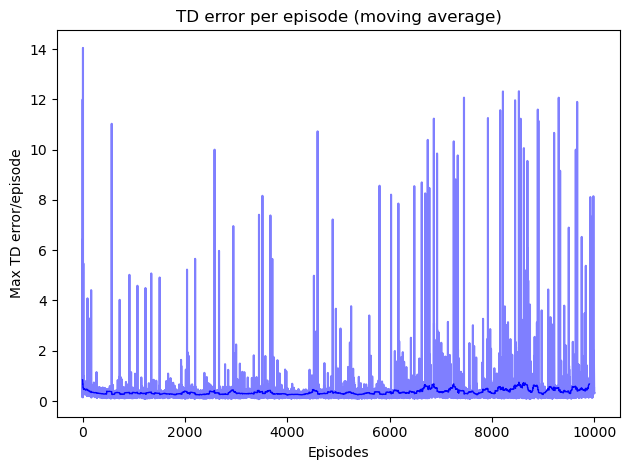

In [22]:
######################## SOLUCIÓ ###########################
window = 100
average_deltas = []
for idx in range(len(deltas) - window + 1):
    average_deltas.append(np.mean(deltas[idx:idx+window]))

plt.subplot()
plt.title('TD error per episode (moving average)')

plt.plot(range(1,len(deltas)+1), deltas,  alpha=0.5, color='blue')
plt.plot(range(1,len(average_deltas)+1), average_deltas,  linewidth=1, alpha=1, color='blue')

plt.xlabel('Episodes')
plt.ylabel('Max TD error/episode')
plt.tight_layout()

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 4.1.3</strong> (0.25 pts)
Imprimir la política trobada amb el mètode SARSA per a cada estat (podeu re-utilitzar la funció creada a l'apartat anterior dels mètodes MC). Es tracta d'una política òptima?
</div>

In [23]:
######################## SOLUCIÓ ###########################
print_policy(Q_sarsa,4,4)

------------------------------------------
  Down  |  Left  |  Left  |  Down  |
------------------------------------------
  Down  |  Left  |  Left  |  Down  |
------------------------------------------
  Down  |  Left  |  Left  |  Down  |
------------------------------------------
  Right  |  Right  |  Right  |  Stay  |
----------------------------------------------


<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentaris:</strong>
<br><br>
La política obtinguda és l'òptima per a totes les caselles.
</div>

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Exercici 4.1.4</strong> (0.25 punts)
Executar un episodi amb la política trobada i mostrar la trajectòria de l'agent i el retorn obtingut. Comentar els resultats.
</div>

In [24]:
######################## SOLUCIÓ ###########################
execute_episode(Q_sarsa,env)

Obs inicial: 0 
Action: Down -> Obs: 4 and reward: -0.1
Action: Down -> Obs: 8 and reward: -0.1
Action: Down -> Obs: 12 and reward: -0.1
Action: Right -> Obs: 13 and reward: -0.1
Action: Right -> Obs: 14 and reward: -0.1
Action: Right -> Obs: 15 and reward: -0.1
Action: Stay -> Obs: 15 and reward: 1.0
Episode finished after 7 timesteps and reward was 0.4 


<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentaris:</strong>
<br><br>
S'aconsegueix arribar a l'objectiu en 7 passes i el retorn és de 0.4.
</div>

### 4.2. Mètode Q-Learning (1.5 punts)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 4.2.1</strong> (0.75 pts)

Implementar l'algoritme *Q-learning* explicat al mòdul 6 "Aprenentatge per Diferència Temporal" y executar-lo utilizant els següents paràmetres:
<ul>    
    <li>Número de episodios = 5.000</li>
    <li>learning rate = 0,4</li>
    <li>discount factor = 1</li>
    <li>epsilon = 0,5</li>
    <li>epsilon decay = 0,9</li>
    <li>mínim valor d'epsilon = 0,05</li>
</ul>
Actualitzar el valor d'epsilon segons: $$\textrm{max}(\epsilon · \epsilon_{\textrm{decay}}, \epsilon_{\textrm{min}})$$
    </div>

In [25]:
env = gym.make("Gym-Gridworlds/Ex2-4x4-v0", render_mode=None)

print("Action space is {} ".format(env.action_space))
print("Observation space is {} ".format(env.observation_space))

Action space is Discrete(5) 
Observation space is Discrete(16) 


In [26]:
######################## SOLUCIÓ ###########################

def update_Q_qlearning(alpha, gamma, Q, state, action, reward, next_state=None):
    """Returns updated Q-value for the most recent experience."""
    current = Q[state][action]  # estimate in Q-table (for current state, action pair)
    # get value of state, action pair at next time step
    Qsa_next = np.max(Q[next_state]) if next_state is not None else 0  # Cambia esta línea
    target = reward + (gamma * Qsa_next)      # construct TD target
    TD_error = target - current
    new_value = current + (alpha * TD_error)  # get updated value
    return new_value, TD_error

def epsilon_greedy(Q, state, nA, eps):
    """Selects epsilon-greedy action for supplied state.

    Params
    ======
        Q (dictionary): action-value function
        state (int): current state
        nA (int): number actions in the environment
        eps (float): epsilon
    """
    if np.random.random() > eps: # select greedy action with probability epsilon
        return np.argmax(Q[state])
    else:                     # otherwise, select an action randomly
        return np.random.choice(np.arange(env.action_space.n))

In [27]:
######################## SOLUCIÓ ###########################
def qlearning(env, num_episodes, alpha, gamma=1.0, epsilon=1, epsdecay=0.99, epsmin=0.01):
    nA = env.action_space.n                # number of actions
    Q = defaultdict(lambda: np.zeros(nA))  # initialize empty dictionary of arrays
    deltas = []
    eps = epsilon
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        score = 0                          # initialize score
        state, info = env.reset()          # start episode
        biggest_change = 0

        while True:
            action = epsilon_greedy(Q, state, nA, eps)  # epsilon-greedy action selection
            next_state, reward, terminated, truncated, info = env.step(action)  # take action A, observe R, S'
            done = terminated or truncated
            score += reward                  # add reward to agent's score

            old_q = Q[state][action]

            if not terminated:
                Q[state][action], TD_error = update_Q_qlearning(alpha, gamma, Q, \
                                                                state, action, reward, next_state)
            else:
                Q[state][action], TD_error = update_Q_qlearning(alpha, gamma, Q, \
                                                                state, action, reward, None)

            state = next_state         # S <- S'
            if done:
                eps = max(epsilon*epsdecay, epsmin)  # set value of epsilon
                break
            biggest_change = max(biggest_change, np.abs(TD_error))
        deltas.append(biggest_change)
    print("")
    return Q, deltas

In [28]:
%%time
######################## SOLUCIÓ ###########################
# obtain the estimated optimal policy and corresponding action-value function
Q_qlearning, deltas = qlearning(env, num_episodes=5000, alpha=0.4, gamma= 1, epsilon=0.5, epsdecay=0.9, epsmin=0.05)

Episode 5000/5000
CPU times: total: 2.31 s
Wall time: 2.17 s


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Exercici 4.2.2</strong> (0.25 pts)
Imprimir una gràfica amb l'evolució del més gran error TD de cada episodi. Atès que l'error té molta variància, imprimiu també la mitjana mòbil amb una finestra temporal de 100 episodis.
</div>

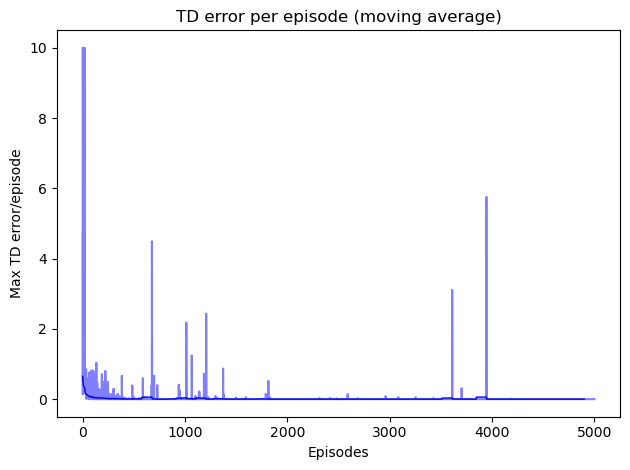

In [29]:
######################## SOLUCIÓ ###########################
window = 100
average_deltas = []
for idx in range(len(deltas) - window + 1):
    average_deltas.append(np.mean(deltas[idx:idx+window]))

plt.subplot()
plt.title('TD error per episode (moving average)')

plt.plot(range(1,len(deltas)+1), deltas,  alpha=0.5, color='blue')
plt.plot(range(1,len(average_deltas)+1), average_deltas,  linewidth=1, alpha=1, color='blue')

plt.xlabel('Episodes')
plt.ylabel('Max TD error/episode')
plt.tight_layout()

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 4.2.3</strong> (0.25 pts)
Imprimir la política trobada amb el mètode Q-learning per a cada estat (podeu re-utilitzar la funció creada a l'apartat anterior). Es tracta d'una política òptima?
</div>

In [30]:
######################## SOLUCIÓ ###########################
print_policy(Q_qlearning,4,4)

------------------------------------------
  Down  |  Left  |  Left  |  Down  |
------------------------------------------
  Down  |  Left  |  Left  |  Down  |
------------------------------------------
  Down  |  Left  |  Left  |  Down  |
------------------------------------------
  Right  |  Right  |  Right  |  Stay  |
----------------------------------------------


<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentaris:</strong>
<br><br>
La política obtinguda és l'òptima per a totes les caselles.
</div>

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Exercici 4.2.4</strong> (0.25 punts)
Executar un episodi amb la política trobada i mostrar la trajectòria de l'agent i el retorn obtingut. Comentar els resultats.
</div>

In [31]:
######################## SOLUCIÓ ###########################
execute_episode(Q_qlearning,env)

Obs inicial: 0 
Action: Down -> Obs: 4 and reward: -0.1
Action: Down -> Obs: 8 and reward: -0.1
Action: Down -> Obs: 12 and reward: -0.1
Action: Right -> Obs: 13 and reward: -0.1
Action: Right -> Obs: 14 and reward: -0.1
Action: Right -> Obs: 15 and reward: -0.1
Action: Stay -> Obs: 15 and reward: 1.0
Episode finished after 7 timesteps and reward was 0.4 


<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentaris:</strong>
<br><br>
S'aconsegueix arribar a l'objectiu en 7 passes i el retorn és de 0.4.
</div>

## 5. Comparativa dels algoritmes (0.5 punts)

En aquest apartat farem una petita comparativa dels mètodes programats en els apartats anteriors.

Compararem el comportament dels algoritmes en termens de la política assolida, la duració de l'entrenament i el factor de descompte.


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Exercici 5.1 - Anàlisi de les polítiques obtingudes i del temps de convergència</strong> (0,25 punts)

Realitzar un estudi de les polítiques obtingudes responent a les següents preguntes:
<ul>
  <li>Tots els algoritmes aconsegueixen arribar a la política òptima?</li>
  <li>Triguen el mateix temps en convergir?</li>
  <li>A què poden ser degudes les diferències?</li>
</ul>
<b>Nota: Es recomana excutar cada algoritme diverses vegades per extreure unes conclusions més consistents.</b>
</div>

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>CONCLUSIONS:</strong>
<br>
    Tots tres mètodes, amb els hiperparàmetres proporcionats, assoleixen la convergència a la política òptima però els mètodes TD (SARSA i Q-learning) ho fan en molts menys episodis que el mètode de Montecarlo, cosa que fa que el temps d'entrenament dels mètodes TD sigui molt inferior a MC. Això és degut a que els mètodes TD es van actualitzant a cada pas i no han d'esperar fins al final de l'episodi per fer l'actualització de l'algoritme com li passa al mètode de Montecarlo.
</div>

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Exercici 5.2 - Influència del factor de descompte (discount factor)</strong> (0,25 punts)

Tots els agents s'han entrenat amb recompenses sense descomptar (factor de descompte = 1). A què creus que es deu aquesta elecció? Creus que millorarien els resultats si s'utilitza un factor de descompte diferent? Per què? En cas afirmatiu, selecciona un nou factor de descompte i testeja'l a algun dels algortimes (per exemple a Q-learning).
</div>

In [32]:
#SOLUCIÓ

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>CONCLUSIONS:</strong>
<br><br>
    
Donat que l'única recompensa positiva es troba al final de l'episodi (a la casella objectiu) es pot considerar que aquesta és la recompensa més important i ha de tenir la mateixa importància que la resta. Per tant, un factor de descompte menor que 1 desvirtuaria el seu valor.
</div>

Tanquem l'entorn perquè als següents apartats en crearem un de nou

In [33]:
env.close()

## 6. Diferència de polítiques entre SARSA i Q-Learning (1.5 punts)

En aquest darrer apartat dissenyarem un entorn una mica més complicat i compararem les diferents polítiques que assoleixen els mètodes SARSA i Q-learning.

Per a això es demana:


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Exercici 6.1</strong> (0,5 punts)

Crear un entorn nou amb una graella 5x5 com la que s'observa a continuació (utilitzeu <code>"5X5_Ex6"</code> com a clau de l'entrada al diccionari <code>GRIDS</code>.):
<br><br>
<img src="images/Gym-Gridworld_Ex6_5x5.png" alt="Mi imagen" style="display: block; margin-left: auto; margin-right: auto;">
<br>
Fixeu-vos que la casella inicial no es troba a dalt a l'esquerra si no a la meitat de la primera columna. Per a aconseguir això heu de crear una sub-classe de la classe <code>Gridworld</code> i afegir-la al final de l'arxiu <code>\gym_gridworlds\gridworld.py</code> (en el mateix arxiu teniu algun exemple).

Enrecordeu-vos de registrar l'entorn a l'arxiu <code>\gym_gridworlds\\\_\_init\_\_.py</code> amb els paràmetres pertinents (fixeu-vos en altres registres com es crida a una sub-classe), reiniciar el kernel del Notebook i tornar a importar els paquets.

L'entorn s'ha de poder cridar amb el següent codi:

</div>

In [34]:
env = gym.make("Gym-Gridworlds/Ex6-5x5-v0", render_mode="human")
env.reset()
env.render()
print("Action space is {} ".format(env.action_space))
print("Observation space is {} ".format(env.observation_space))

Action space is Discrete(5) 
Observation space is Discrete(25) 


In [35]:
env.close()

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Exercici 6.2 - Entrenament i comparativa dels agents</strong> (1 punt)

<ol>
  <li>Entrena els 2 agents TD (SARSA i Q-learning) en el nou entorn. Ajusta els diferents paràmetres fins que els algoritmes convergeixin.</li>
  <li>Imprimeix per pantalla la política assolida per cada agent.</li>
  <li>Executa un episodi amb cada política i mostra els resultats (accions, recorregut i recompensa total).</li>
  <li>Comenta els resultats. Són els resultats esperats?</li>
</ol>

</div>

In [44]:
env = gym.make("Gym-Gridworlds/Ex6-5x5-v0", render_mode=None)

print("Action space is {} ".format(env.action_space))
print("Observation space is {} ".format(env.observation_space))

Action space is Discrete(5) 
Observation space is Discrete(25) 


In [45]:
%%time
######################## SOLUCIÓ ###########################
#Entrenament SARSA
# obtain the estimated optimal policy and corresponding action-value function
Q_sarsa, deltas = sarsa(env, num_episodes=30000, alpha=0.3, gamma= 1, epsilon=0.9, epsdecay=0.9, epsmin=0.05)

Episode 30000/30000
CPU times: total: 59 s
Wall time: 56.9 s


In [38]:
env = gym.make("Gym-Gridworlds/Ex6-5x5-v0", render_mode=None)

In [39]:
%%time
######################## SOLUCIÓ ###########################
#Entrenament Q-learning
# obtain the estimated optimal policy and corresponding action-value function
Q_qlearning, deltas = qlearning(env, num_episodes=30000, alpha=0.3, gamma= 1, epsilon=0.75, epsdecay=1, epsmin=0.05)

Episode 30000/30000
CPU times: total: 41.3 s
Wall time: 40.3 s


In [46]:
######################## SOLUCIÓ ###########################
#Política SARSA
print_policy(Q_sarsa,5,5)

------------------------------------------
  Right  |  Right  |  Right  |  Right  |  Down  |
------------------------------------------
  Up  |  Left  |  Left  |  Left  |  Down  |
------------------------------------------
  Up  |  Left  |  Stay  |  Left  |  Left  |
------------------------------------------
  Up  |  Down  |  Up  |  Up  |  Up  |
------------------------------------------
  Up  |  Right  |  Right  |  Up  |  Right  |
----------------------------------------------


In [47]:
######################## SOLUCIÓ ###########################
#Execució episodi SARSA
execute_episode(Q_sarsa,env)

Obs inicial: 10 
Action: Up -> Obs: 5 and reward: -0.1
Action: Up -> Obs: 0 and reward: -0.1
Action: Right -> Obs: 1 and reward: -0.1
Action: Right -> Obs: 2 and reward: -0.1
Action: Right -> Obs: 3 and reward: -0.1
Action: Right -> Obs: 4 and reward: -0.1
Action: Down -> Obs: 9 and reward: -0.1
Action: Down -> Obs: 14 and reward: -0.1
Action: Left -> Obs: 13 and reward: -0.1
Action: Left -> Obs: 12 and reward: -0.1
Action: Stay -> Obs: 12 and reward: 1.0
Episode finished after 11 timesteps and reward was 1.1102230246251565e-16 


In [42]:
######################## SOLUCIÓ ###########################
#Política O-learning
print_policy(Q_qlearning,5,5)

------------------------------------------
  Right  |  Right  |  Right  |  Right  |  Down  |
------------------------------------------
  Down  |  Left  |  Left  |  Left  |  Down  |
------------------------------------------
  Down  |  Left  |  Stay  |  Left  |  Left  |
------------------------------------------
  Down  |  Down  |  Up  |  Up  |  Left  |
------------------------------------------
  Right  |  Right  |  Right  |  Up  |  Left  |
----------------------------------------------


In [43]:
######################## SOLUCIÓ ###########################
#Execució episodi Q-learning
execute_episode(Q_qlearning,env)

Obs inicial: 10 
Action: Down -> Obs: 15 and reward: -0.1
Action: Down -> Obs: 20 and reward: -0.1
Action: Right -> Obs: 21 and reward: -0.1
Action: Right -> Obs: 22 and reward: -0.1
Action: Right -> Obs: 23 and reward: -0.1
Action: Up -> Obs: 18 and reward: -0.1
Action: Up -> Obs: 13 and reward: -0.1
Action: Left -> Obs: 12 and reward: -0.1
Action: Stay -> Obs: 12 and reward: 1.0
Episode finished after 9 timesteps and reward was 0.20000000000000007 


<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>CONCLUSIONS:</strong>
<br>
En base als resultats obtinguts s'observa que:  
<ul>
  <li>Tots 2 arriben a assolir l'objectiu.</li>
  <li>Q-learning aprèn la política òptima. Arriba en 9 passes i obté un retorn de 0.2</li>
  <li>SARSA aprèn una política sub-òptima més conservadora. Arriba en 11 passes i obté un retorn de 0, però evita passar a prop de les caselles amb major penalització.</li>
</ul>
Aquest comportament dels 2 algoritmes és l'esperat tal i com es va veure al mòdul de teoria.
</div>